# <span style="color:rgb(106,127,16)">The Singular Value Decomposition</span>


<div style="text-align: right"><span style="color:rgb(106,127,16)">April 27, 2020
    </span></div>
<br>




One of the early and natural ideas in software development for scientific computation was the idea of packaging linear algebra software around robust implementations of  matrix factorizations, divested from specific applications. This enabled durable linear algebra tools like [LAPACK](http://www.netlib.org/lapack/) to be developed with a stable interface, usable across  numerous application domains. Commercial software like matlab, as well as open-source software like octave, numpy and scipy, all take full advantage of these developments.   What does this mean for you as a data scientist?  When you are faced with a specific computational task, if you are able to reformulate your task using off-the-shelf implementations of matrix factorizations, then you might already be half-way to finishing your task.


You already know about some matrix factorizations. In your introductory linear algebra prerequisite course, you learnt about eigenvalues and eigenvectors. The computation of eigenvalues and eigenvectors is indeed the computation of a matrix factorization. This factorization is called a **diagonalization** or an **eigenvalue decomposition** of an $n \times n$ matrix $A$ and it takes the form 
$$
A = X D X^{-1}
$$
where $D$ is a diagonal matrix and $X$ is an invertible matrix, both of the same size as $A$. The eigenvalues of $A$ are found in the diagonal entries of $D$ and the eigenvectors are columns of $X$, as can be see by rewriting the factorization as
$$
A X = X D. 
$$
I think you have already seen the importance of eigenvalues in varied applications, so I'll not stress it further. 


Another important factorization is the SVD, or the **singular value decomposition**, which often does not get the emphasis it deserves in lower division courses.  In some ways the SVD is even more important that a diagonalization. This is because not all matrices have a diagonalization. In contrast, using basic real analysis results, one can prove that any matrix has an SVD.  We shall see that from an SVD, one can read off the important properties of a matrix and  easily construct compressed approximations of the matrix. 

## Definition of SVD

The SVD is a factorization of an $m \times n$ matrix $A$ of the form 
$$
A = U \Sigma V^*
$$
where $\Sigma$ is am $m \times n$ diagonal matrix, and $U$ and $V$ are unitary matrices of sized  $m \times m$ and $n \times n$, respectively. (Recall that a square matrix $Q$ is called unitary if its inverse equals  $Q^*$, the conjugate transpose of $Q$.) The diagonal entries of $\Sigma$ are non-negative and positive ones are called the **singular values** of $A$. It is a convention to list the singular values in non-increasing order along the diagonal. The columns of $U$ and $V$ are called the left and right **singular vectors**, respectively. 


Here is how we compute SVD using `scipy`. 

In [1]:
from scipy.linalg import svd
import numpy as np
np.set_printoptions(precision=3, suppress=True)

In [2]:
a = np.random.rand(4, 5) + 1j * np.random.rand(4, 5)
u, s, vh = svd(a)

In [3]:
u @ u.T.conjugate()        # u is unitary. Its columns are left singular vectors

array([[ 1.+0.j,  0.+0.j, -0.-0.j, -0.+0.j],
       [ 0.-0.j,  1.+0.j,  0.+0.j,  0.-0.j],
       [-0.+0.j,  0.+0.j,  1.+0.j,  0.-0.j],
       [-0.-0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [4]:
vh @ vh.T.conjugate()      # Rows of vh are right singular vectors

array([[ 1.+0.j, -0.+0.j,  0.-0.j, -0.+0.j,  0.+0.j],
       [-0.-0.j,  1.+0.j,  0.+0.j,  0.-0.j, -0.-0.j],
       [ 0.+0.j,  0.-0.j,  1.+0.j,  0.-0.j,  0.-0.j],
       [-0.-0.j,  0.+0.j,  0.+0.j,  1.+0.j, -0.-0.j],
       [ 0.-0.j, -0.+0.j,  0.+0.j, -0.+0.j,  1.+0.j]])

In [5]:
s     # Only the diagonal entries of Sigma are returned in s

array([3.401, 1.243, 0.953, 0.423])

## The algebra of SVD

An *outer product* of an $x \in \mathbb{R}^m$ and $y \in \mathbb{R}^n$, is the 
$m \times n$ matrix $x y^*$ (which being the product of $m \times 1$ and $1 \times n$ matrices, is of shape $m \times n$). Reversing the order of $x$ and $y^*$ in the product, we of course get the familiar *inner product*, which is a $1 \times 1$ matrix, or a scalar. 

Although the outer product is an $m \times n$ matrix, with $mn$ entries, it only takes $m+n$ entries to completely specify it (namely the entries of $x$ vector and the $y$ vector). Note that the columns of the outer product $x y^*$ are 
$$
\bar{y}_1 x,\; \bar{y}_2 x,  \ldots, \;\bar{y}_n x.
$$
In other words all columns are scalar multiples of the same vector $x$. Therefore, whenever $x$ is a nontrivial vector, the dimension of the *range* (or the *column space*) of the matrix is 1. Recall from your linear algebra prerequisite that this dimension is what we call *rank*. All outer products are of unit rank (unless one of the vectors is trivial).

A very useful way to think of the SVD is to expand the factorization as follows. Naming the columns of $U$ and $V$ as $u_i$ and $v_j$, we have
$$
A = U \Sigma V^* = [u_1, \ldots, u_m] 
\begin{bmatrix}
\sigma_1 &          &  \\
         & \sigma_2   \\ 
         &          & \ddots
\end{bmatrix}
[v_1, \ldots, v_n]^*
= 
\sum_{l=1}^{\min(m, n)} \sigma_l \; u_l v_l^*.
$$
Thus the SVD can be viewed as a sum of unit rank outer products. Each summand increases rank (if the corresponding singular value is nonzero) until the rank of $A$ is reached. Let's see this in action for a small matrix. 

In [6]:
a = np.random.rand(4, 5)
u, s, vh = svd(a)

Numpy's broadcasting rules do not make it easy to make the  outer product $u_l v_l^*$ simply. You have to place a `newaxis` in the right places to make it work:

In [7]:
u[0, :, np.newaxis] @ vh[np.newaxis, 0, :]

array([[ 0.116,  0.264,  0.167,  0.163,  0.27 ],
       [-0.018, -0.041, -0.026, -0.025, -0.042],
       [ 0.207,  0.473,  0.299,  0.291,  0.484],
       [-0.083, -0.189, -0.12 , -0.117, -0.194]])

Or, alternately, you can use `np.outer`:

In [8]:
np.outer(u[0, :], vh[0, :])

array([[ 0.116,  0.264,  0.167,  0.163,  0.27 ],
       [-0.018, -0.041, -0.026, -0.025, -0.042],
       [ 0.207,  0.473,  0.299,  0.291,  0.484],
       [-0.083, -0.189, -0.12 , -0.117, -0.194]])

Executing the sum $\sum_l \sigma_l (u_l v_l^*)$, we find that it is equal to `a`:

In [9]:
ar = np.zeros_like(a)
for i in range(4):
    ar += np.outer(u[:, i], s[i] * vh[i, :])
ar

array([[0.001, 0.799, 0.077, 0.022, 0.572],
       [0.068, 0.455, 0.361, 0.243, 0.6  ],
       [0.017, 0.057, 0.587, 0.254, 0.851],
       [0.701, 0.736, 0.308, 0.674, 0.216]])

In [10]:
a

array([[0.001, 0.799, 0.077, 0.022, 0.572],
       [0.068, 0.455, 0.361, 0.243, 0.6  ],
       [0.017, 0.057, 0.587, 0.254, 0.851],
       [0.701, 0.736, 0.308, 0.674, 0.216]])

The factors of the SVD tell us all the important properties of the a matrix immediately. If you enjoy linear algebra, you should try to prove the following simple result yourself.

**Theorem.** Suppose $A = U \Sigma V^*$ is the SVD of an $m \times n$ matrix $A$. Then the following statements hold.
1. The rank of $A$ is the number of nonzero singular values. 
2. A basis for the range (column space) of $A$ is $\{u_1, u_2, \ldots, u_r\}$.
3. A basis for the null space (kernel) of $A$ is $\{ v_{r+1}, \ldots, v_{n-1}, v_n\}$.
4. The singular values of $A$ are non-negative square roots of eigenvalues of $A^*A$.

Notice how the rank-nullity theorem (something you may have been tortured with in your first linear algebra course) follows as a trivial consequence of items (2) and (3).

## The geometry of SVD

The geometry of any linear operator in $\mathbb{R}^n$ is easy to describe: application of a matrix transforms (hyper)spheres to (hyper)ellipses - if you did not know this, you will momentarily see this from the code below. Unitary operators are special in that they are coordinate changes that maps (hyper)spheres to (hyper)spheres. In general unitary operators don't change angles - they include operations like rotation and reflection in higher dimensions. 

The presence of unitary factors in the SVD is significant. The SVD provides a geometrical decomposition of a linear operator  into factors $U$ and $V^*$ that  do not change the shapes, and a factor $\Sigma$ that stretches axial directions (so that the shape change is transparent). Let us see this in action for a $ 2 \times 2$ matrix.

In [11]:
a = np.array([[0.1, 0.5], [0.4, 0.8]])
u, s, vh = svd(a)

To see how the geometry gets transformed (squashed) by the linear operator (matrix) `a`, we first plot the unit circle and the parts of the $x$ and $y$ axis within it. Then, we track how these points are mapped by `a`, as well as by each of the components of the SVD of `a`.

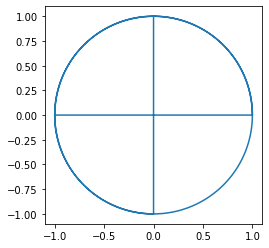

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def show(c):
    plt.plot(c[0, :], c[1, :])
    plt.axis('image');

# plot the unit circle and axis segments:

t = np.linspace(0, 3.5 * np.pi , num=300)
l = np.linspace(-1, 1, num=10)
z = np.zeros_like(l)
c = np.array([np.concatenate([l, np.cos(t), z]), np.concatenate([z, np.sin(t), l])])
show(c)    

This is what `a` does to this geometry: 

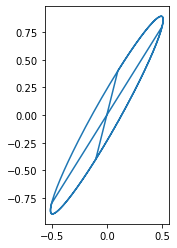

In [13]:
show(a @ c)

Now, let us see this transformation as a composition of the following three geometrical operations:

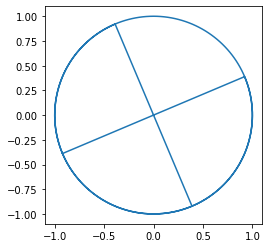

In [14]:
show(vh @ c)

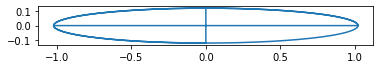

In [15]:
show(np.diag(s) @ c)

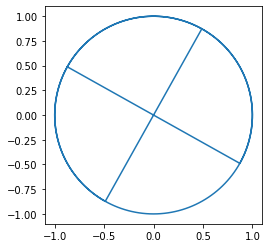

In [16]:
show(u @ c)

When you compose these operations, you indeed get the transformation generated by `a`.

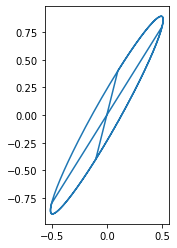

In [17]:
show(u @ np.diag(s) @ vh @ c)

## Low rank approximation


There are many ways of expressing a matrix as a sum of low rank matrices, e.g., 

$$
\begin{bmatrix}
a & b \\
c & d 
\end{bmatrix}
= 
\begin{bmatrix}
a & 0 \\ 0 & 0  
\end{bmatrix}
+ 
\begin{bmatrix}
0 & b \\ 0 & 0 
\end{bmatrix}
+ 
\begin{bmatrix}
0 & 0 \\ c & 0 
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\ 0 & d 
\end{bmatrix}.
$$

Each of the matrices on the right can have rank at most one.

As we have already seen, the SVD also expresses $A$ as a sum of rank-one outer products. However, the way the SVD does this, is special in that a low-rank minimizer can be read off the SVD, as described in the following (Eckart-Young-Mirksy) theorem. Here we compare matrices of the same size using the *Frobenius* norm
$$
\| A \|_F = \bigg( \sum_{i, j} |A_{ij}|^2 \bigg)^{1/2}.
$$
The theorem answers the following question: how close can we get to $A$ using matrices whose rank is much lower than the rank of $A$?

**Theorem.** Suppose $A$ be an $m \times n$ matrix (complex or real). For any $0 \le \ell \le r = \text{rank}(A)$, define the matrix 
$$
A_\ell = \sum_{j=1}^{\ell} \sigma_j u_j v_j^*,
$$
using the singular values $\sigma_j$ and the left and right singular vectors $u_j, v_j$ of $A$,  i.e., $A_\ell$ is the sum of the first $\ell$ terms of the SVD when written as a sum of outer products.  Then, the minimum of $ \| A - B \|_F$ over all $m \times n$ matrices $B$ of rank not more than $\ell$ is attained by $\| A - A_\ell \|_F$ and the minimum is 
$(\sigma_{\ell+1}^2 + \cdots + \sigma_r^2)^{1/2}$.


This matrix approximation result is perhaps easily visualized using images. Think of an image as a matrix. Using `matplotlib`'s `imread` we can load PNG images. Here is an example. 

In [18]:
cats = plt.imread('../figs/GeoLea.png')
cats.shape

(1040, 758, 4)

This is a 3-dimensional array because images are represented using RGBA values at each pixel (red, green, blue and an alpha value for transparency). However this image of my cats is actually a black and white image, so all RGB values are the same, as can be verified immediately: 

In [19]:
np.linalg.norm(cats[..., 0] - cats[..., 2], 'fro')

0.0

Note that above I have squeezed in two things that may be new for you: the use of the [ellipsis](https://docs.python.org/dev/library/constants.html#Ellipsis)  to leave the dimension of a numpy slice unspecified, and the way to compute the Frobenius norm in numpy. Restricting to the first of the three identical channels, we continue:

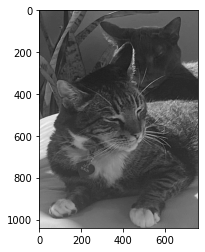

In [20]:
c = cats[..., 0]  
plt.imshow(c, cmap='gray');

Let us take the SVD of this 1040 x 758 matrix.

In [21]:
u, s, vh = svd(c)

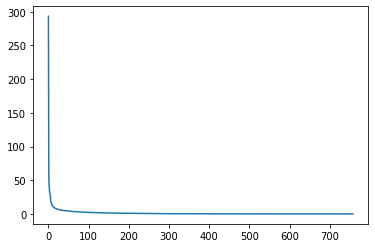

In [22]:
plt.plot(s)

You can see a sharp drop in the magnitude of the singular values. This is a good indication that the later summands in the SVD representation of $A$,  
$$
A = \sum_{j=1}^{\min(m, n)} \sigma_j u_j v_j^*
$$
are adding much less to $A$ than the first few summands. Therefore, we should be able to represent the same $A$ using the first few outer products. 

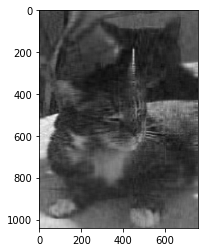

In [23]:
# Rank 20 approximation of the cats:

l = 20;   cl = u[:, :l] @ np.diag(s[:l]) @ vh[:l, :]
plt.imshow(cl, cmap='gray');

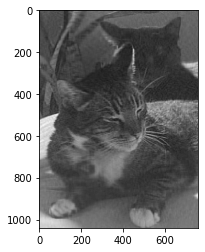

In [24]:
# Rank 50 approximation of the cats:

l = 50;   cl = u[:, :l] @ np.diag(s[:l]) @ vh[:l, :]
plt.imshow(cl, cmap='gray');

If you increase the rank `l` to 100, you will find that the result is visually indistinguishable from the original. 

Returning to the theorem, let us note that the theorem also gives one the ability to specify an error tolerance and let that dictate the choice of the rank $\ell$. As an example, suppose I declare I want a low-rank approximation within the following relative error in Frobenius norm:

In [25]:
relative_error = 1.e-1

Then we can find the needed $\ell$ using an aggregation and masking as follows.

In [26]:
s2 = s**2
total = np.sum(s2)
diff = np.sqrt((total - np.add.accumulate(s2)) / total)
l = np.argmax(diff < relative_error) + 1
l

41

Then here is the needed low rank approximation:

In [27]:
cl = u[:, :l] @ np.diag(s[:l]) @ vh[:l, :]

You can check that the error is indeed less than the prescribed error tolerance. 

In [28]:
np.linalg.norm(c - cl, 'fro') / np.linalg.norm(c, 'fro')

0.09942439

As you can see, the low rank approximation does give some image compression. The number of entries needed to store a rank $\ell$ approximation `cl` of an $m \times n$ matrix  is $m \ell + \ell + \ell n$:

In [29]:
u.shape[0] * l + l + l * vh.shape[0]

73759

In contrast, to store the original image (single channel) we would need to minimally store $mn$ numbers:

In [30]:
c.shape[0] * c.shape[1]

788320

So clearly, we have some compression. However, for image compression, there are better algorithms. 


The  utility of the low-rank approximation technique using the SVD is not really in image compression, but rather in other applications that leverage the operator. Being an compressed approximation of an *operator* (i.e., a matrix) is much more than just a compressed visual image. For example, one can not only reduce the storage for a matrix, but also reduce the time to apply the operator to a vector using a low-rank approximation. Because the SVD tells us the essentials of an operator in lower dimensional spaces, it continues to find new applications in many modern emerging concepts.




<hr>




<span style="color:rgb(106,127,16); font-size:8pt">These materials were created by</span> [<span style="color:rgb(106,127,16); font-size:8pt">Jay Gopalakrishnan</span>](http://web.pdx.edu/~gjay/) <span style="color:rgb(106,127,16); font-size:8pt">for a sophomore course (MTH 271) offered during the Spring 2020 quarter at Portland State University, and are made available under the</span> [<span style="color:rgb(106,127,16) ; font-size:8pt">CC-BY-SA license</span>](https://creativecommons.org/licenses/by-sa/4.0/legalcode).
 



